In [2]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [55]:
x_data_list = [1, 2, 3, 4, 5]
y_data_list = [3, 2, 3, 1, 0]
def plot_basic_data(parameters_list=None, title="Observed data"):
    xlim = [-1, 7]
    fig, ax = plt.subplots()
    if parameters_list is not None:
        x_pred = np.linspace(xlim[0], xlim[1], 100)
        for parameters in parameters_list:
            y_pred = parameters[0] + parameters[1] * x_pred
            ax.plot(x_pred, y_pred, ':', color=[1, 0.7, 0.6])
            parameters = parameters_list[-1]
            y_pred = parameters[0] + parameters[1] * x_pred
            ax.plot(x_pred, y_pred, "-", color=[1, 0, 0], lw=2)
            ax.plot(x_data_list, y_data_list, "ob")
            ax.set(xlabel="Input x", ylabel="Output y", title=title, xlim=xlim, ylim=[-2, 5])
            ax.grid()
            plot_basic_data()

In [56]:
parameters_list = []

Line Function: -0.85 * x + 4.5
[[0.77, 0.85], [4.5, -0.85]]


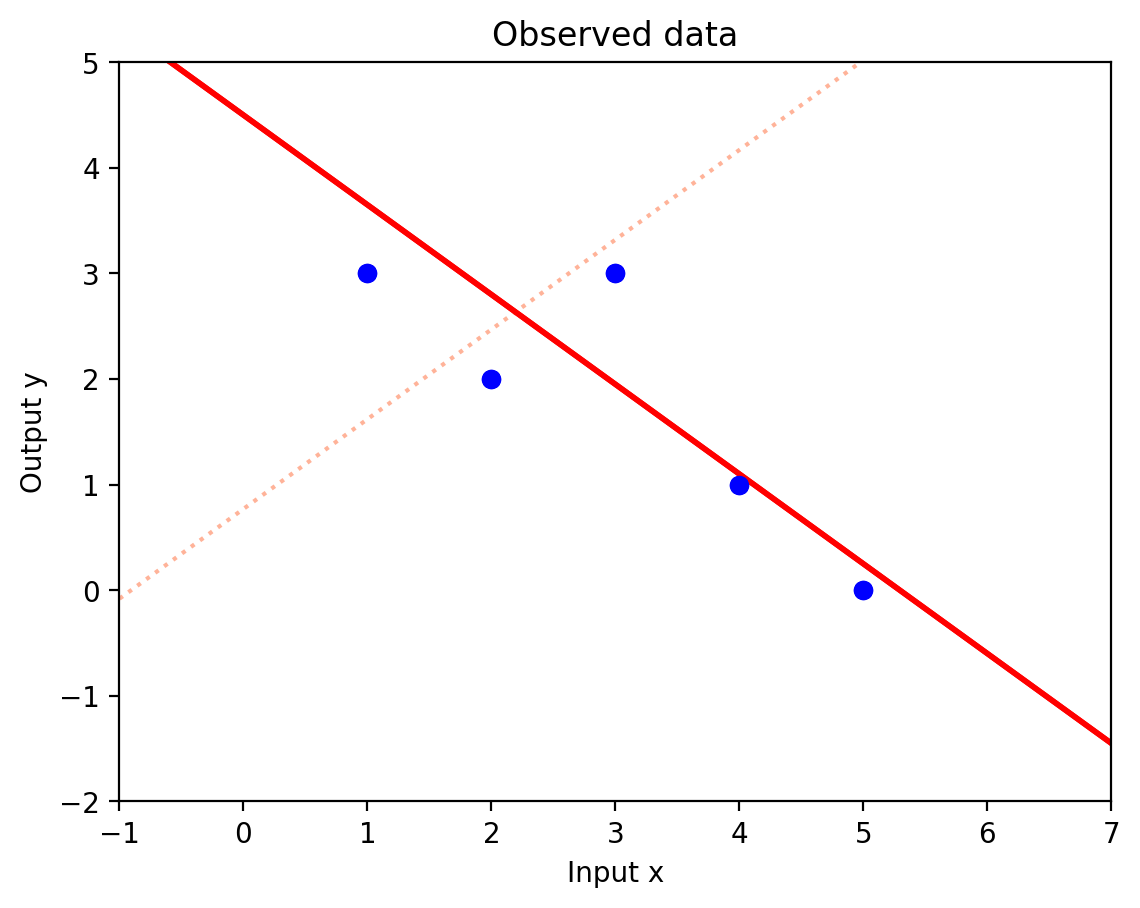

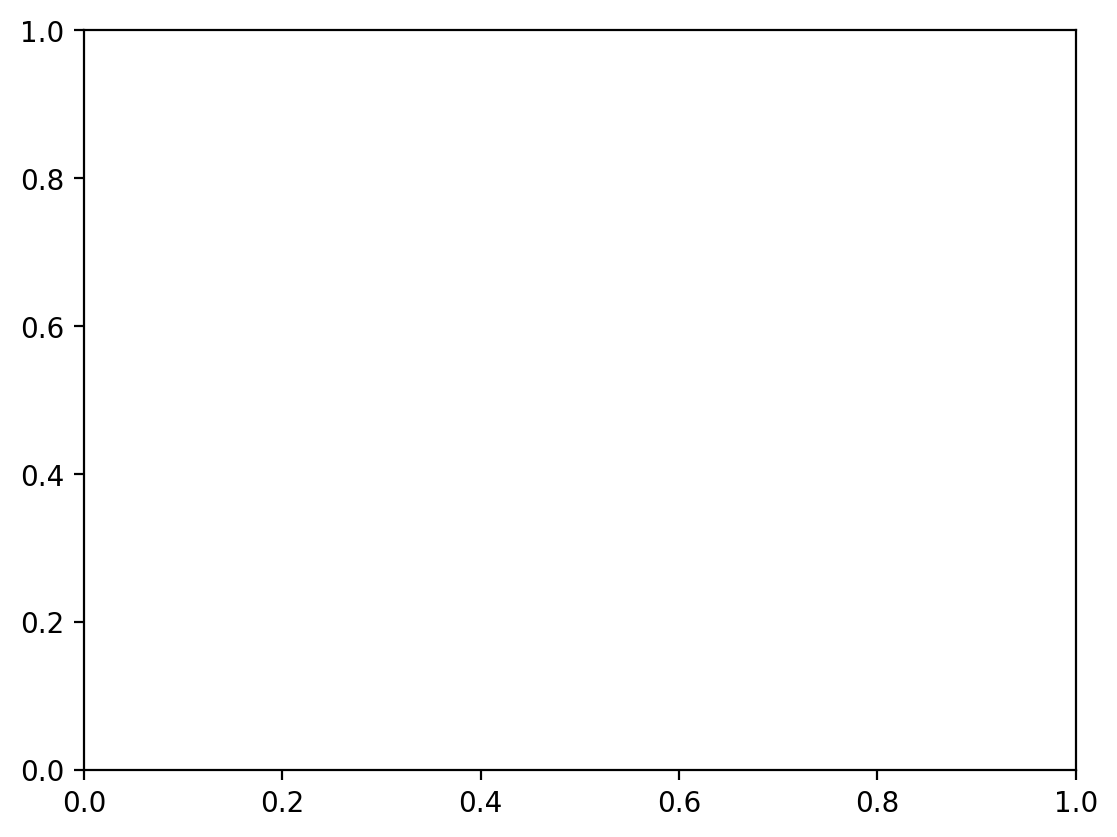

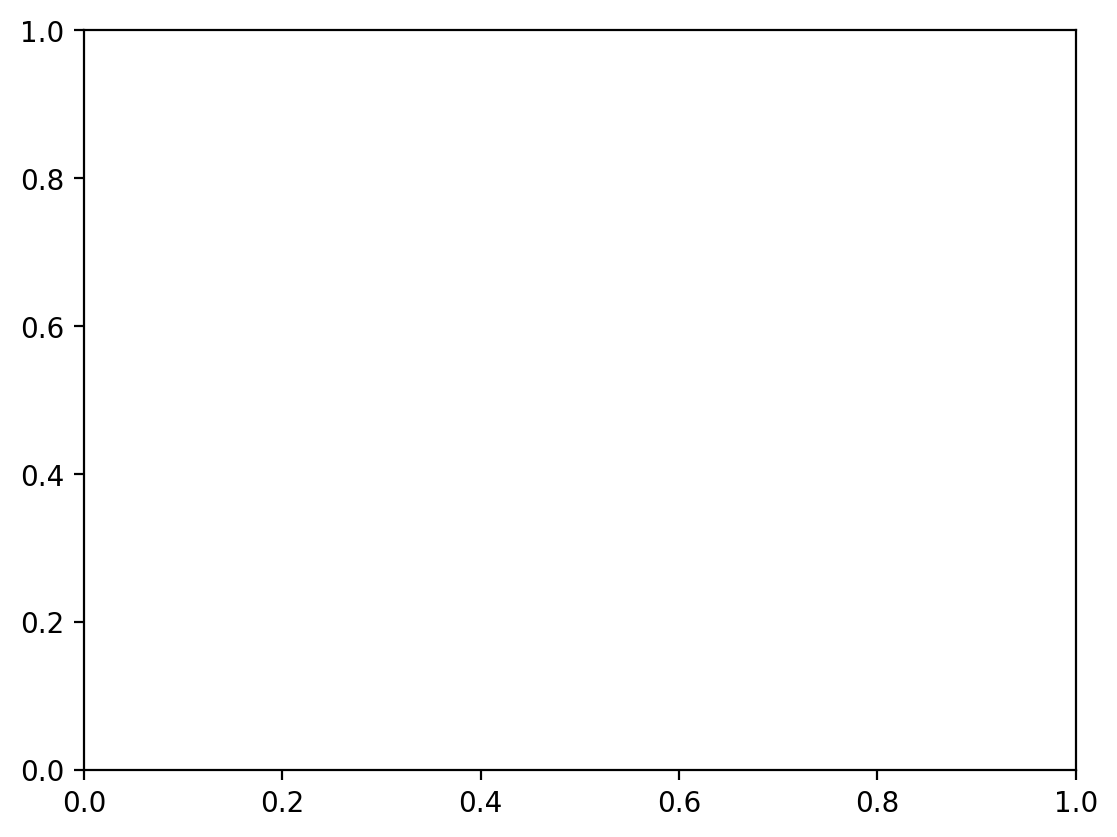

In [58]:
b = 4.5 # Bias
w = -0.85 # Weight
print("Line Function:", w, "* x +", b)
parameters = [b, w]
parameters_list.append(parameters)
print(parameters_list)
plot_basic_data(parameters_list)

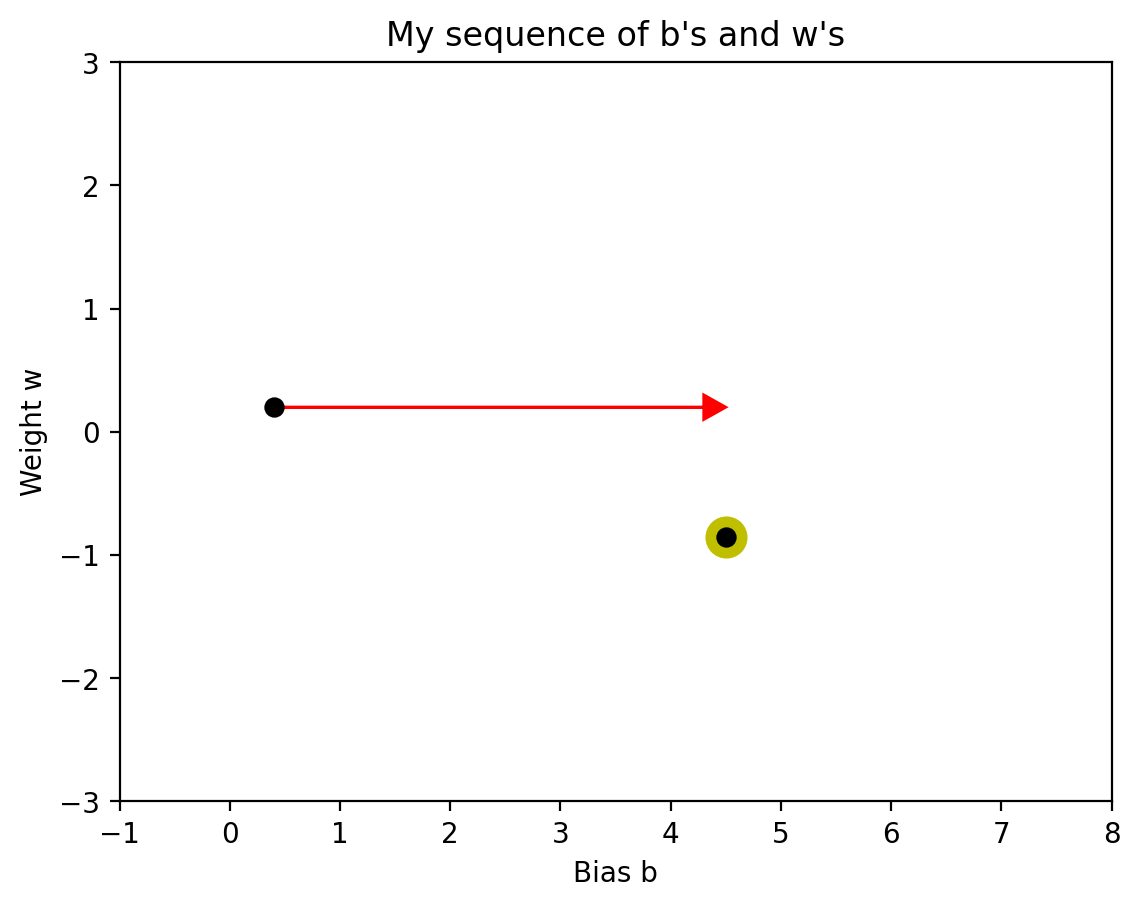

In [7]:
fig, ax = plt.subplots()
opt = {"head_width": 0.2, "head_length": 0.2, "length_includes_head": True, "color": "r"}
if parameters_list is not None:
    b_old = parameters_list[0][0]
    w_old = parameters_list[0][1]
    for i in range(1, len(parameters_list)):
        b_next = parameters_list[i][0]
        w_next = parameters_list[i][1]
        ax.arrow(b_old, w_old, b_next - b_old, w_next - w_next, **opt)
        b_old, w_old = b_next, w_next
        ax.scatter(b_old, w_old, s=200, marker="o", color="y")
        bs = [parameters[0] for parameters in parameters_list]
        ws = [parameters[1] for parameters in parameters_list]
        ax.scatter(bs, ws, s=40, marker="o", color="k")
        ax.set(xlabel="Bias b", ylabel="Weight w", title="My sequence of b\'s and w\'s", xlim=[-1, 8], ylim=[-3, 3])
        plt.show

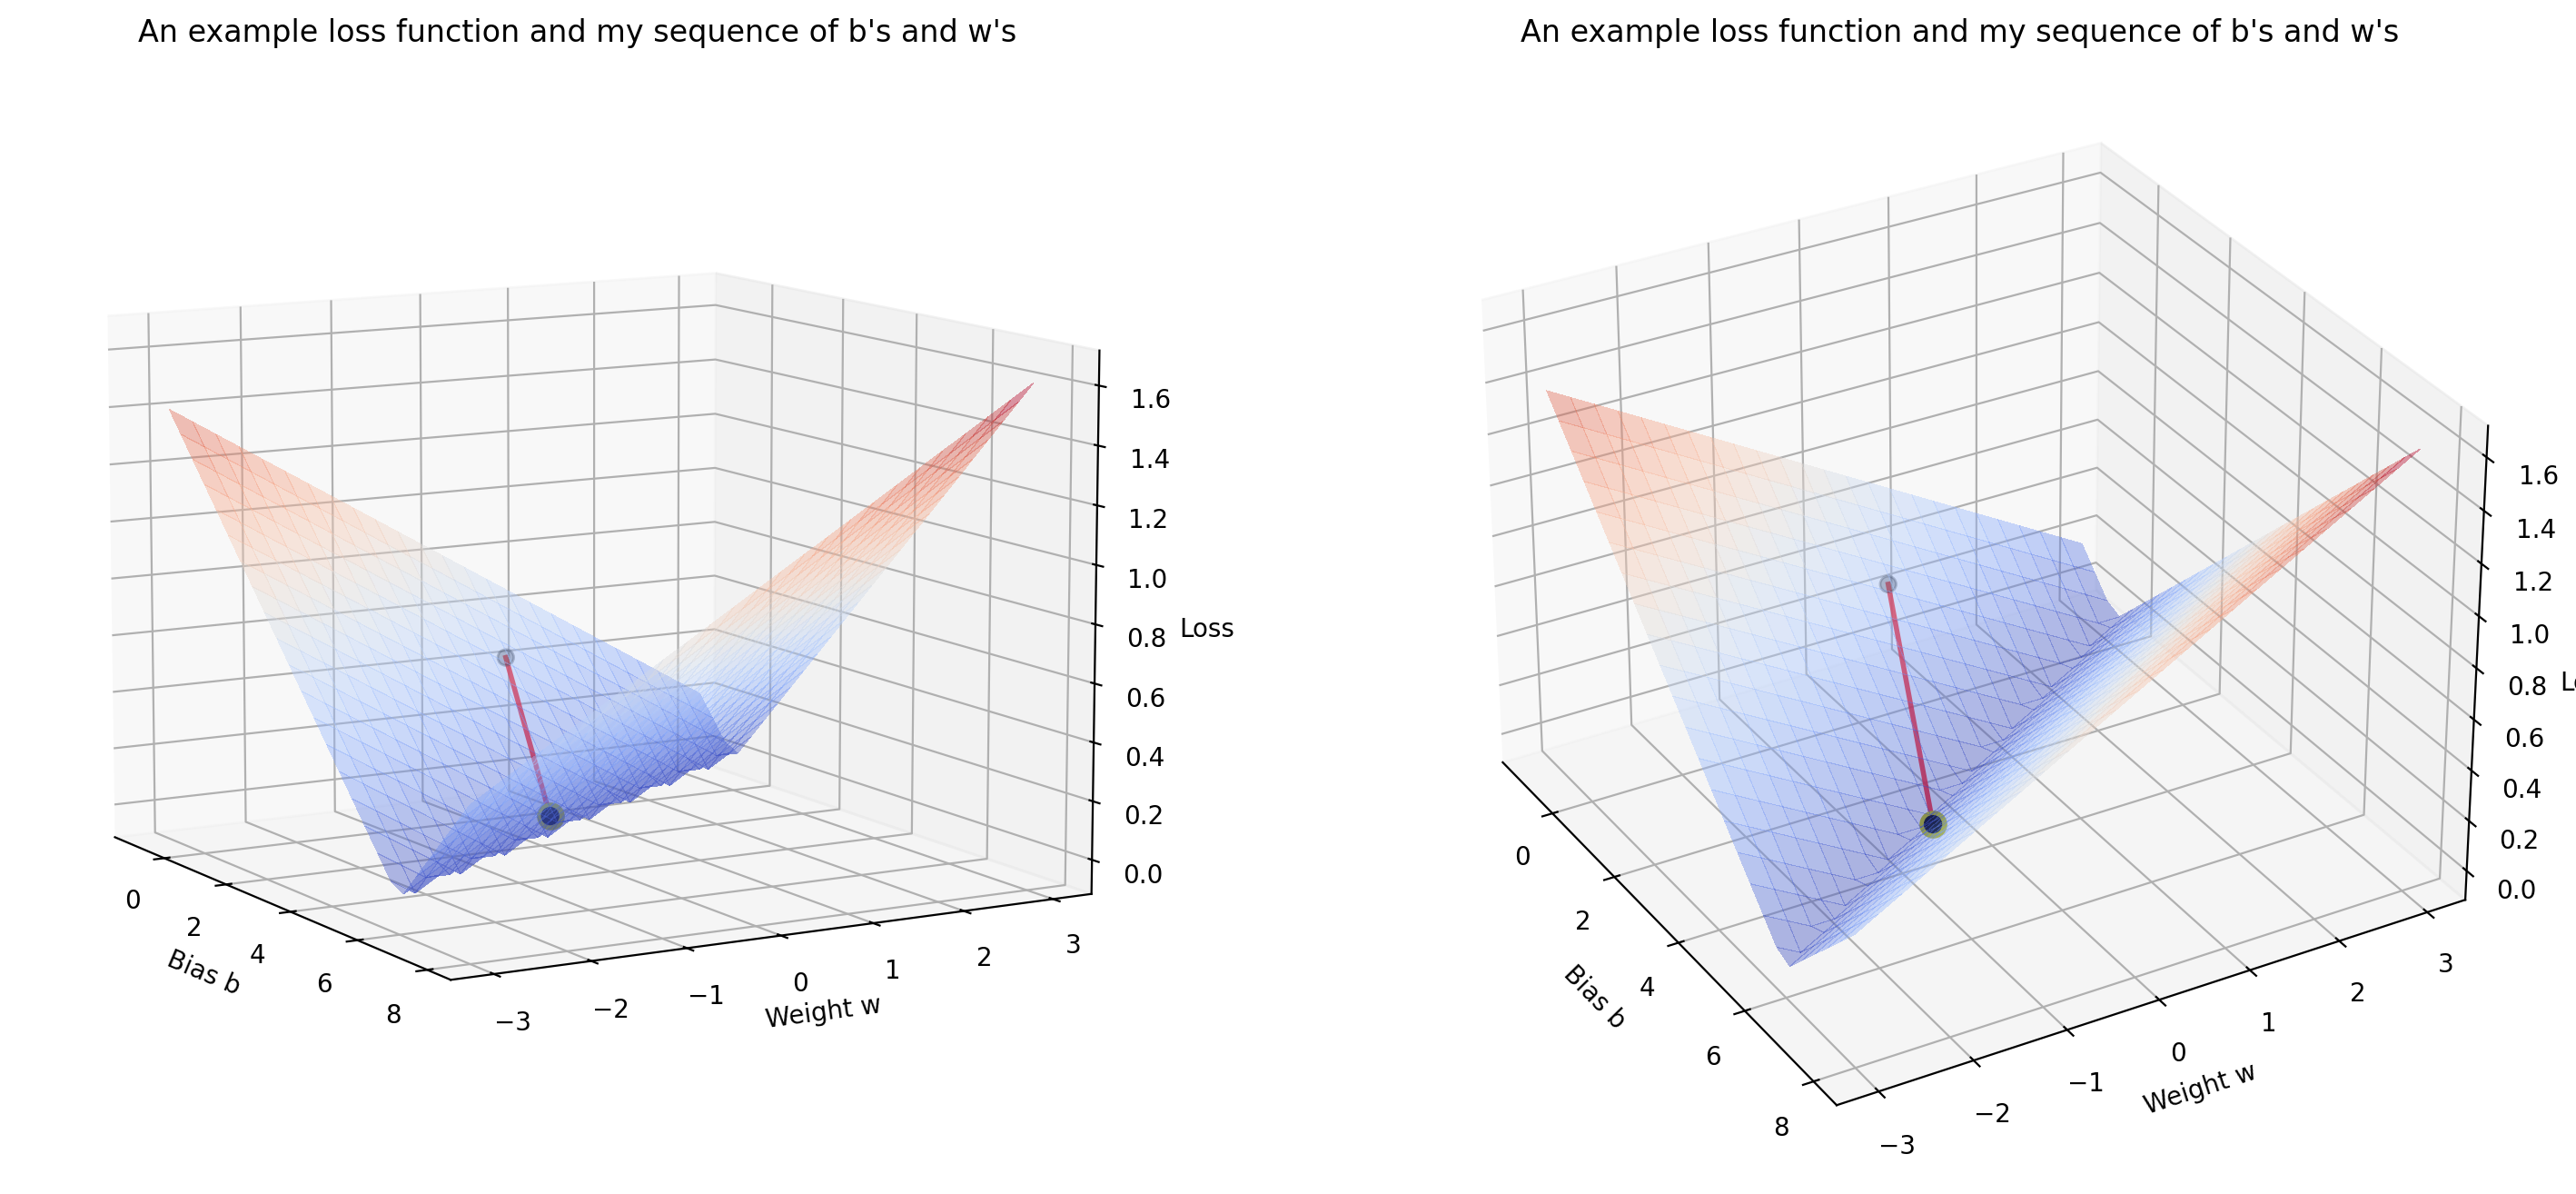

In [8]:
def l1_loss(b, w):
    loss = 0 * b
    for x, y in zip(x_data_list, y_data_list):
        f = w * x + b
        loss += np.abs(f - y)
        return loss / len(x_data_list)

bs, ws = np.linspace(-1, 8, num=25), np.linspace(-3, 3, num=25)
b_grid, w_grid = np.meshgrid(bs, ws)
loss_grid = l1_loss(b_grid, w_grid)

def plt_loss(parameters_list, title, show_stops=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), subplot_kw={"projection": "3d"})
    ax[0].view_init(10, -30)
    ax[1].view_init(30, -30)

    if parameters_list is not None:
        b_old = parameters_list[0][0]
        w_old = parameters_list[0][1]
        loss_old = l1_loss(b_old, w_old)
        ls = [loss_old]

        for i in range(1, len(parameters_list)):
            b_new = parameters_list[i][0]
            w_new = parameters_list[i][1]
            loss_new = l1_loss(b_new, w_new)
            ls.append(loss_new)

            ax[0].plot([b_old, b_new], [w_old, w_new], [loss_old, loss_new], color="red", alpha=0.8, lw=2)
            ax[1].plot([b_old, b_new], [w_old, w_new], [loss_old, loss_new], color="red", alpha=0.8, lw=2)
            b_old, w_old, loss_old = b_new, w_new, loss_new

        if show_stops:
            ax[0].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
            ax[1].scatter(b_old, w_old, loss_old, s=100, marker="o", color="y")
            bs = [parameters[0] for parameters in parameters_list]
            ws = [parameters[1] for parameters in parameters_list]
            ax[0].scatter(bs, ws, ls, s=40, marker="o", color="k")
            ax[1].scatter(bs, ws, ls, s=40, marker="o", color="k")
        else:
            ax[0].scatter(b_old, w_old, loss_old, s=40, marker="o", color="k")
            ax[1].scatter(b_old, w_old, loss_old, s=40, marker="o", color="k")

        ax[0].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
        ax[1].plot_surface(b_grid, w_grid, loss_grid, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)
        ax[0].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
        ax[1].set(xlabel="Bias b", ylabel="Weight w", zlabel="Loss", title=title)
        plt.show()

plt_loss(parameters_list, "An example loss function and my sequence of b\'s and w\'s", show_stops=True)

In [9]:
def manual_grad(b, w):
    grad_b = 0
    grad_w = 0
    for x, y in zip(x_data_list, y_data_list):
        f = w * x + b
        grad_b += np.sign(f - y)
        grad_w += np.sign(f - y) * x
    grad_b /= len(x_data_list)
    grad_w /= len(x_data_list)
    return grad_b, grad_w

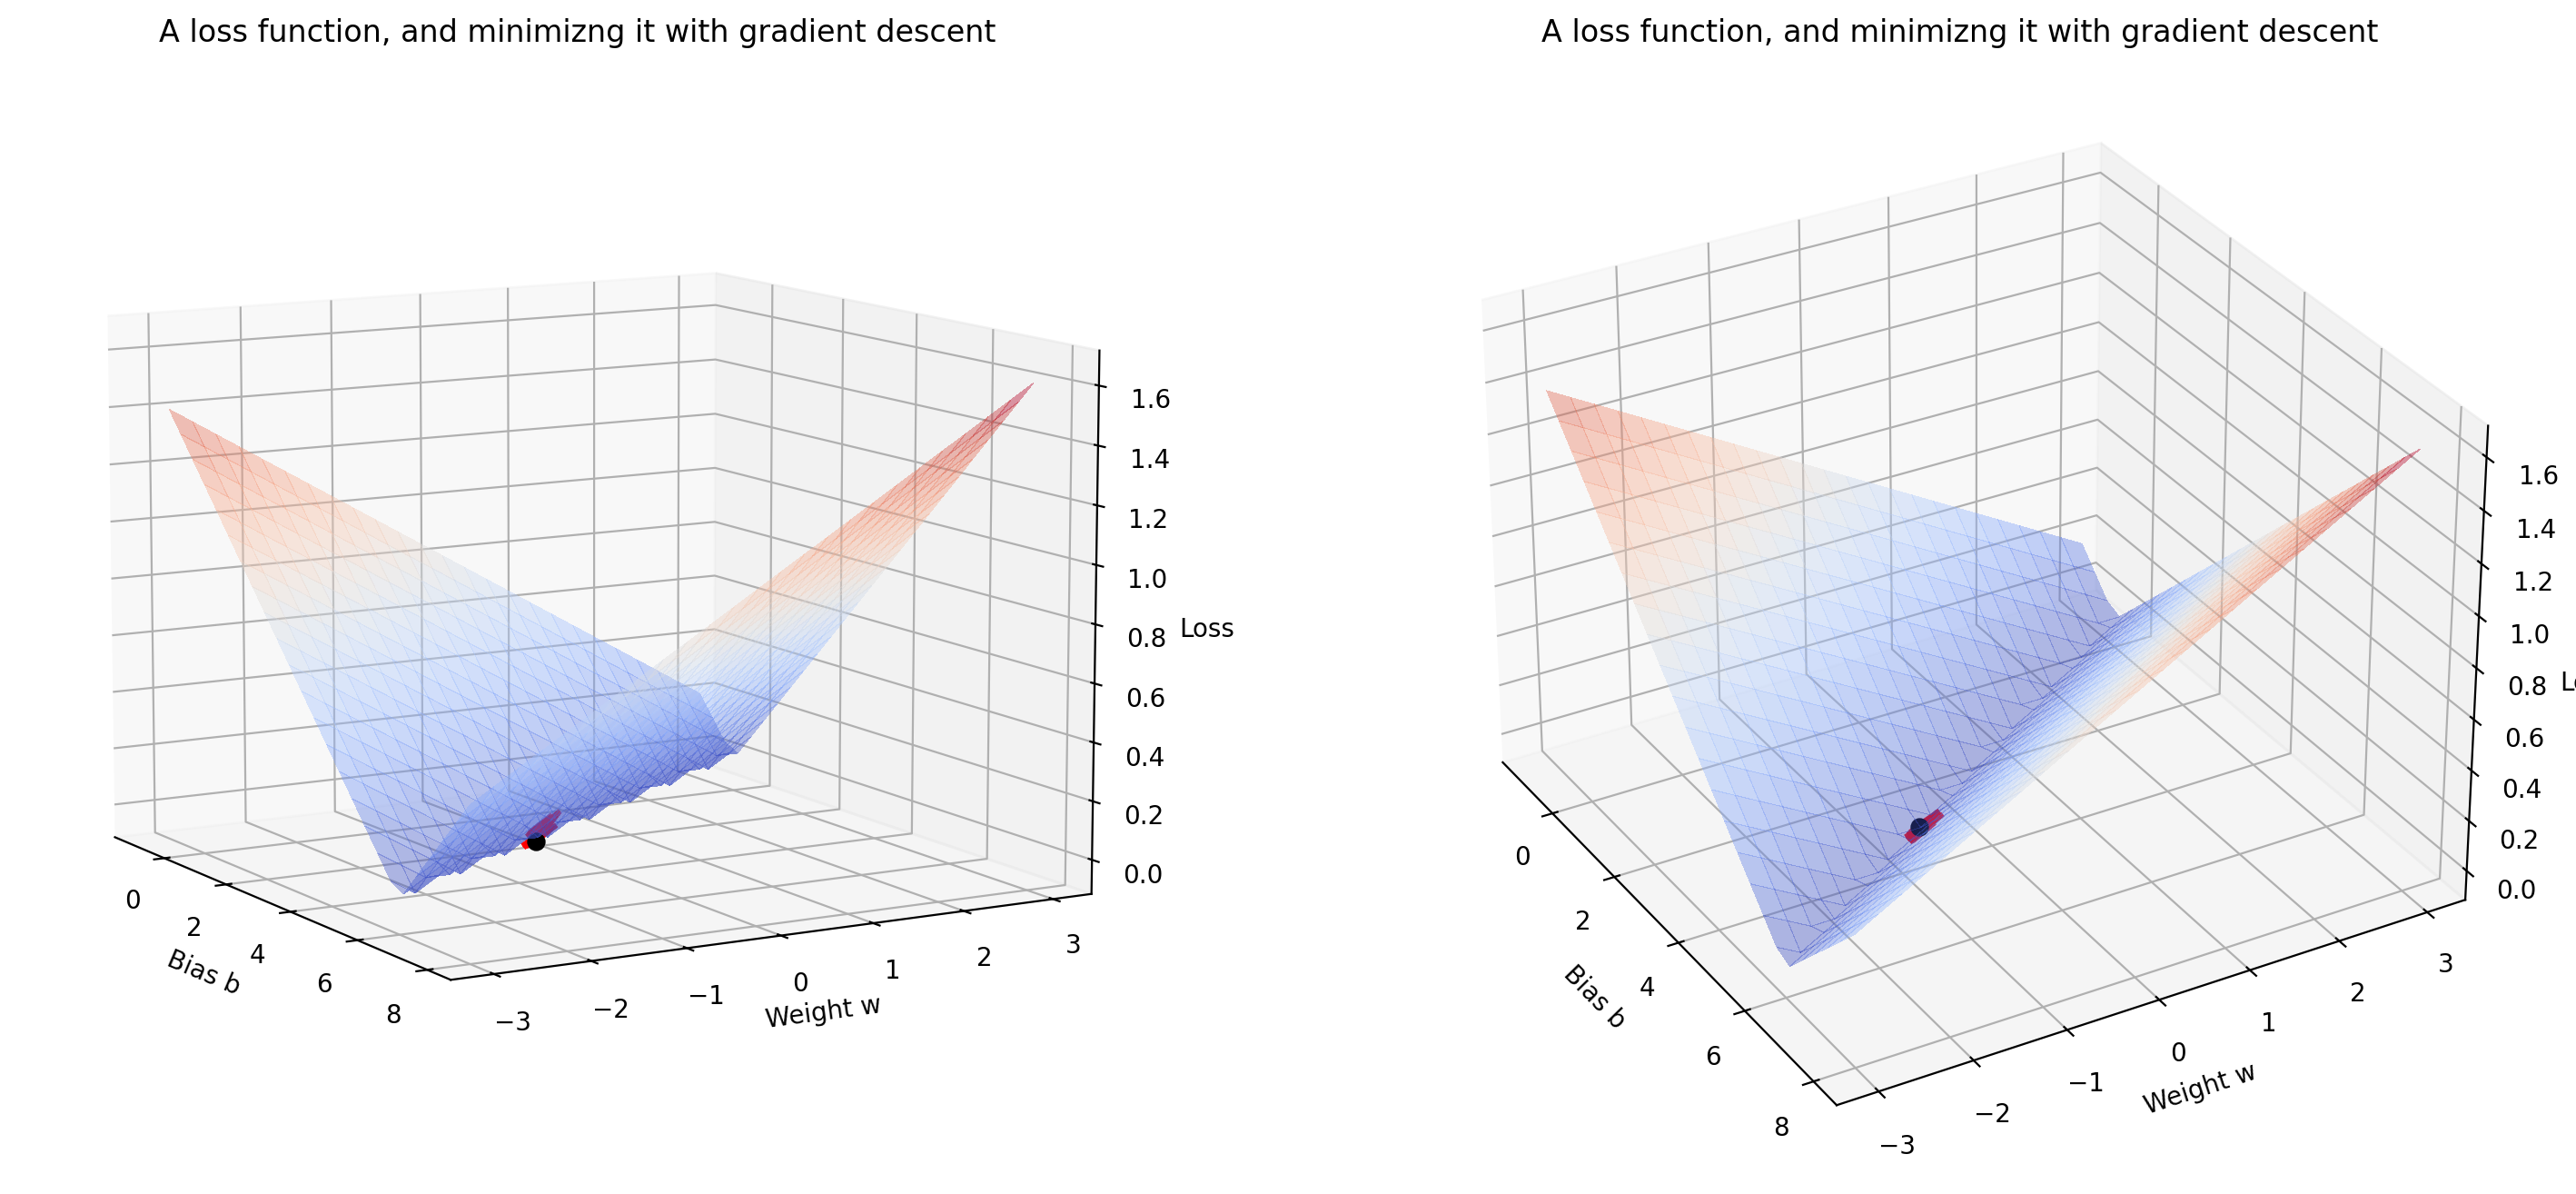

In [10]:
b = 4.5
w = -0.85
learning_rate = 0.1

parameters_step_list = []

for _ in range(200):
    parameters_step_list.append([b, w])
    grad_b, grad_w = manual_grad(b, w)
    b = b - learning_rate * grad_b
    w = w - learning_rate * grad_w

plt_loss(parameters_step_list, "A loss function, and minimizng it with gradient descent")

In [15]:
x = np.array(x_data_list)
y = np.array(y_data_list)

def loss_funtion(b, w):
    f = w * x + b
    errors = jnp.abs(f - y)
    return jnp.mean(errors)

auto_grad = jax.grad(loss_funtion, argnums=(0, 1))

b, w = 4.5, -0.85

grad_b, grad_w = auto_grad(b, w)
print("Auto grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

grad_b, grad_w = manual_grad(b, w)
print("\nManual grad:\n", "Grad b:" , grad_b, "\n", "Grad w:" , grad_w)

Auto grad:
 Grad b: 0.6 
 Grad w: 1.8

Manual grad:
 Grad b: 0.6 
 Grad w: 1.8
